# Python notebook for post-processing apical responses.
# Frequency analysis of results data.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
import glob
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fftpack import fft, rfft
from scipy.interpolate import interp1d
from scipy.io.wavfile import write
from scipy import signal


#### Select a results directory, one or more regions and set analysis frame range.


In [2]:
%matplotlib widget

# global variables
results_sel = ""  # the selected results directory
regions_sel = []  # the selected region(s)
stim_start = 100  # analysis start frame
stim_done = 250   # analysis end frame
data_labels = []

s = {'description_width':'200px'} # a default widget style

# create results directory widget
result_dirs = sorted([f.split('/')[-2] for f in glob.glob("../results/*/", recursive=False)], key=str.casefold)
results_widget = widgets.Select(options=result_dirs, description='Results dir', 
                            disabled=False, layout=widgets.Layout(width='400px'))
# create regions widget
regions_widget = widgets.SelectMultiple(options=[], description='Region', 
                            disabled=False, layout=widgets.Layout(width='400px'))
# create numeric input widgets
stim_start_widget = widgets.BoundedIntText(value=stim_start, min=0, max=1000, step=1,
                    description='Stimulation start frame', disabled=False, layout={'width':'270px'}, style=s)
stim_done_widget = widgets.BoundedIntText(value=stim_done, min=0, max=1000, step=1,
                    description='Stimulation done frame', disabled=False, layout={'width':'270px'}, style=s)

# create status widget
status_widget = widgets.HTML(value=' ', description=' ')

# update the regions based on the results directory selection
def update_regions(*args):
  global data_labels
  if results_widget.value == None:
    return
  region_files = os.listdir("../results/" + results_widget.value)
  region_files = sorted([f for f in region_files if 'apical_region' in f and '.csv' in f])
  regions_widget.options = region_files
  # get the data labels
  with open("../results/" + results_widget.value + "/labels.txt") as f:
    data_labels = f.readlines()
  data_labels = [x.strip() for x in data_labels] 

# widget change callbacks
results_widget.observe(update_regions, 'value')

# display and respond to the widgets
update_regions()
def f(w1, w2, w3, w4, w5):
  global results_sel, region_sel
  global stim_start, stim_done
  results_sel = results_widget.value
  region_sel = regions_widget.value
  stim_start = stim_start_widget.value
  stim_done = stim_done_widget.value

  if not region_sel:
    if not results_sel:
      status_widget.value = "No result directory selected."
    else:
      status_widget.value = "No region(s) selected."
  else:
    status_widget.value = "Selection OK."
display(widgets.interactive(f, w1=results_widget, w2=regions_widget, w3=status_widget,
                           w4=stim_start_widget, w5=stim_done_widget))

interactive(children=(Select(description='Results dir', layout=Layout(width='400px'), options=('20200701-20144…

#### DIAGNOSTIC: Display the analysis portion of the first region data.

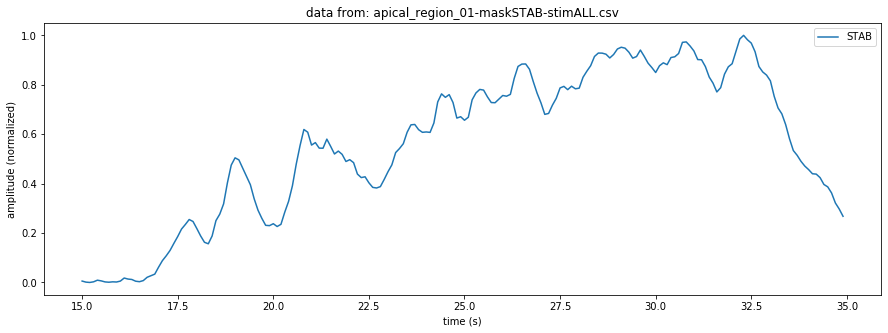

In [3]:
%matplotlib inline

A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + region_sel[0], delimiter=','))
A = A0[:,stim_start:stim_done]

tmin = np.min(A[0])
tmax = np.max(A[0])
trng = tmax-tmin
tstp = A0[0,1]-A0[0,0]

dmin = np.min(A[1:])
dmax = np.max(A[1:])
drng = dmax-dmin

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15,5])
X0 = A[0]
Y0 = (A[1:]-dmin) / drng  # normalized to range(0, 1.0)
ax.plot(X0,np.transpose(Y0))

ax.set_title("data from: " + region_sel[0])
ax.legend(data_labels)
ax.set(ylabel="amplitude (normalized)")
ax.set(xlabel="time (s)")

plt.show()
plt.close() # frees up memory


#### DIAGNOSTIC: Frequency analysis detail in the first region.


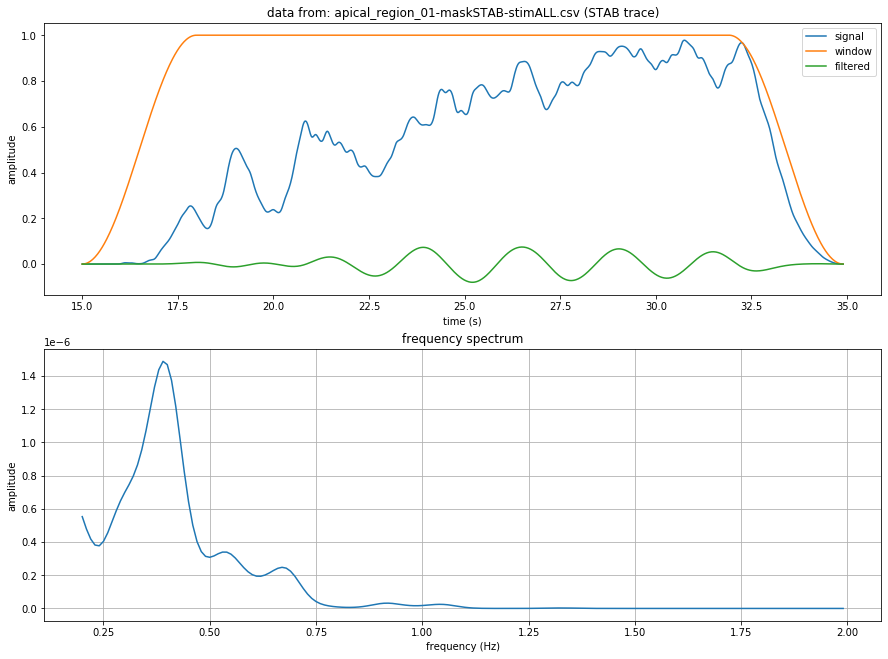

dominant frequency: 0.39Hz


In [5]:
%matplotlib inline

idx = 0

# upsample the data
sr = 50                                                 # a new sample rate (for interpolation)
f = interp1d(X0, Y0[idx], kind='cubic')                 # define the resampling function
X = np.linspace(tmin, tmax, (trng*sr)+1, endpoint=True) # define the new time steps
Y = f(X)                                                # resample the original signal

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = [15,11])
             
wdw = signal.tukey(len(Y), alpha=0.3)      # define a windowing function
ax[0].plot(X,wdw*Y,label="signal")         # plot the windowed signal
ax[0].plot(X,wdw,label="window")           # plot the window itself

# use a filter bank for selective frequency response determination
fX = np.arange(0.2, 2.0, 0.01)             # filter bank frequencies (min, max, step)
fY = []                                    # filter bank responses (rms)
Ya = []                                    # list of all the filtered signals
for s in fX:
  sos = signal.butter(2, (s-0.05,s+0.05), btype='bandpass', fs=sr, output='sos')
  #ofs = np.exp(s)/40.0
  #sos = signal.butter(2, (s-ofs,s+ofs), btype='bandpass', fs=sr, output='sos')
  Y1 = wdw*signal.sosfilt(sos, wdw*Y)      # filter the windowed signal and window the result
  Ya.append(Y1)                            # save a copy of the filtered signal
  fY.append(np.mean(Y1**2)**2)             # save the rms value of the filtered signal

ax[1].plot(fX,fY)    # plot the frequency response
ax[1].grid(b=True)

_,pks = signal.find_peaks(fY,height=0)         # find peaks
didx = fY.index(np.max(pks["peak_heights"]))   # get index of dominant frequency
ax[0].plot(X,Ya[didx],label="filtered")  # plot the signal filtered by the dominant frequency

ax[0].set_title("data from: " + region_sel[0] + " (" + data_labels[idx] + " trace)")
ax[0].legend()
ax[0].set(ylabel="amplitude")
ax[0].set(xlabel="time (s)")

ax[1].set_title("frequency spectrum")
ax[1].set(ylabel="amplitude")
ax[1].set(xlabel="frequency (Hz)")
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.show()
plt.close() # frees up memory
print("dominant frequency:", "{:3.3}Hz".format(fX[didx]))


#### Frequency analysis over all traces in the selected regions.

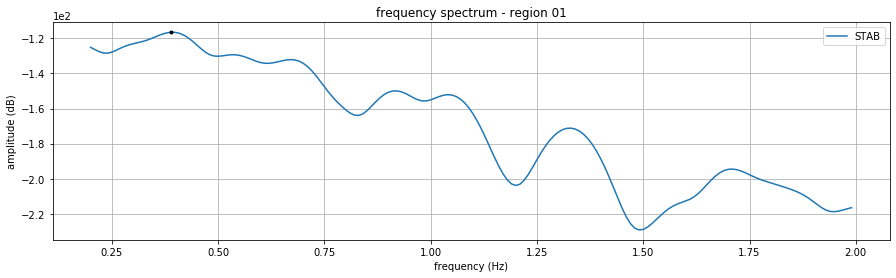

dominant frequencies:  ['0.39Hz']


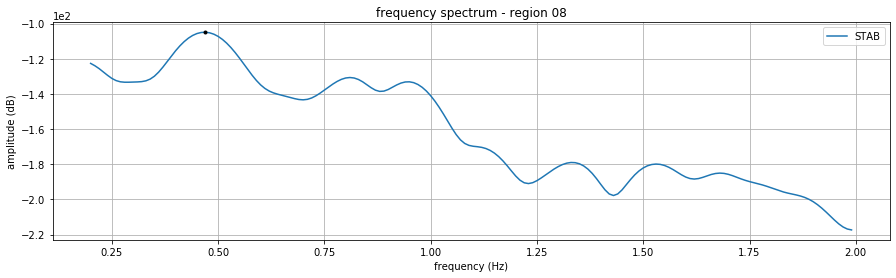

dominant frequencies:  ['0.47Hz']


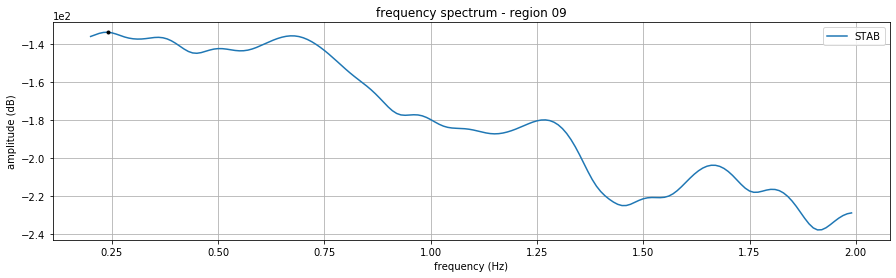

dominant frequencies:  ['0.24Hz']


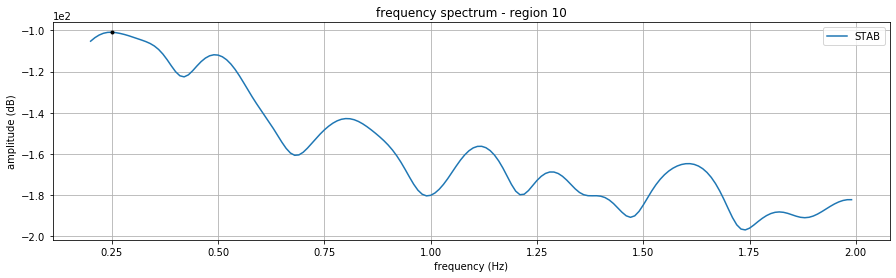

dominant frequencies:  ['0.25Hz']


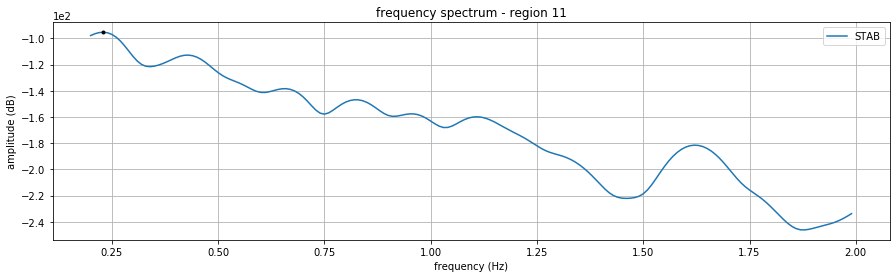

dominant frequencies:  ['0.23Hz']


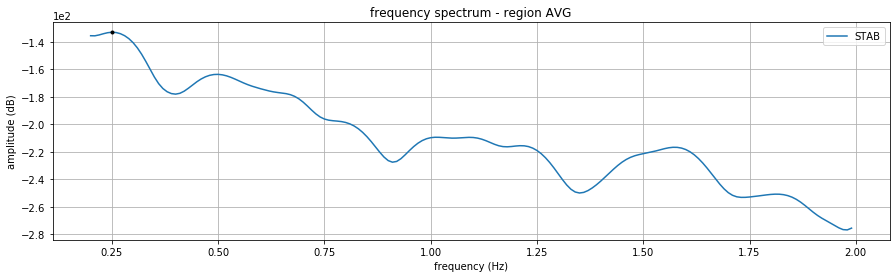

dominant frequencies:  ['0.25Hz']


In [6]:
%matplotlib inline

sr = 50   # a new sample rate (for interpolation)
for r in region_sel:

  region = r.split('_')[-1].split('-')[0]
  A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + r, delimiter=','))
  A = A0[:,stim_start:stim_done]

  tmin = np.min(A[0])
  tmax = np.max(A[0])
  trng = tmax-tmin
  tstp = A0[0,1]-A0[0,0]

  dmin = np.min(A[1:])
  dmax = np.max(A[1:])
  drng = dmax-dmin

  X0 = A[0]
  Y0 = (A[1:]-dmin) / drng  # normalized to range(0, 1.0)

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15,4])
  ax.grid(b=True)

  fq = []  # list of the dominant frequencies
  for idx,y in enumerate(Y0):
    f = interp1d(X0, y, kind='cubic')                       # define the resampling function
    X = np.linspace(tmin, tmax, (trng*sr)+1, endpoint=True) # define the new time steps
    Y = f(X)                                                # resample the original signal

    # use a filter bank for selective frequency response determination
    wdw = signal.tukey(len(Y), alpha=0.3)      # define a windowing function
    fX = np.arange(0.2, 2.0, 0.01)            # filter bank frequencies (min, max, step)
    fY = []                                    # filter bank responses (rms)
    for s in fX:
      sos = signal.butter(2, (s-0.05,s+0.05), btype='bandpass', fs=sr, output='sos')
      #ofs = np.exp(s)/40.0
      #sos = signal.butter(2, (s-ofs,s+ofs), btype='bandpass', fs=sr, output='sos')
      Y1 = wdw*signal.sosfilt(sos, wdw*Y)      # filter the windowed signal and window the result
      fY.append(np.mean(Y1**2)**2)             # save the rms value of the filtered signal
    ax.plot(fX,20*np.log10(fY),label=str(data_labels[idx]))

    _,pks = signal.find_peaks(fY,height=0)        # find peaks
    didx = fY.index(np.max(pks["peak_heights"]))  # get index of dominant frequency
    fq.append("{:3.3}Hz".format(fX[didx]))
    ax.plot(fX[didx],20*np.log10(fY[didx]),'k.')

  ax.legend()
  ax.set_title("frequency spectrum - region " + region)
  ax.set(ylabel="amplitude (dB)")
  ax.set(xlabel="frequency (Hz)")
  ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

  plt.show()
  plt.close() # frees up memory
  print("dominant frequencies: ", fq)


#### TRIAL: FFT based frequency analysis

samples: 4096


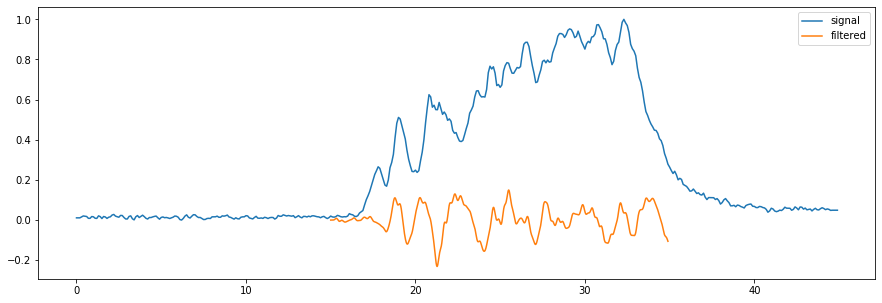

In [9]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15, 5])

idx = 1
A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + region_sel[0], delimiter=','))
dmin = np.min(A0[idx])
dmax = np.max(A0[idx])
drng = dmax-dmin

X0 = A0[0]
Y0 = (A0[idx]-dmin) / drng  # normalized to range(0, 1.0)
ax.plot(X0,Y0,label="signal")

n = 12
p = 2**n
print("samples:", p)
start = 100
stop = 250

f = interp1d(X0, Y0, kind='cubic')
X = np.linspace(tmin, tmax, p, endpoint=True)
tmin = np.min(X)
tmax = np.max(X)
trng = tmax-tmin

Y = f(X)
sos = signal.butter(10, (0.2,4.0), btype='bandpass', fs=p/trng, output='sos')
Yf = signal.sosfilt(sos, Y)
ax.plot(X,Yf,label="filtered")

ax.legend()
plt.show()
plt.close() # frees up memory


In [10]:

write("../results/" + results_sel + "/data" + str(idx) + ".wav", int(p/trng), Yf)


2048 4096


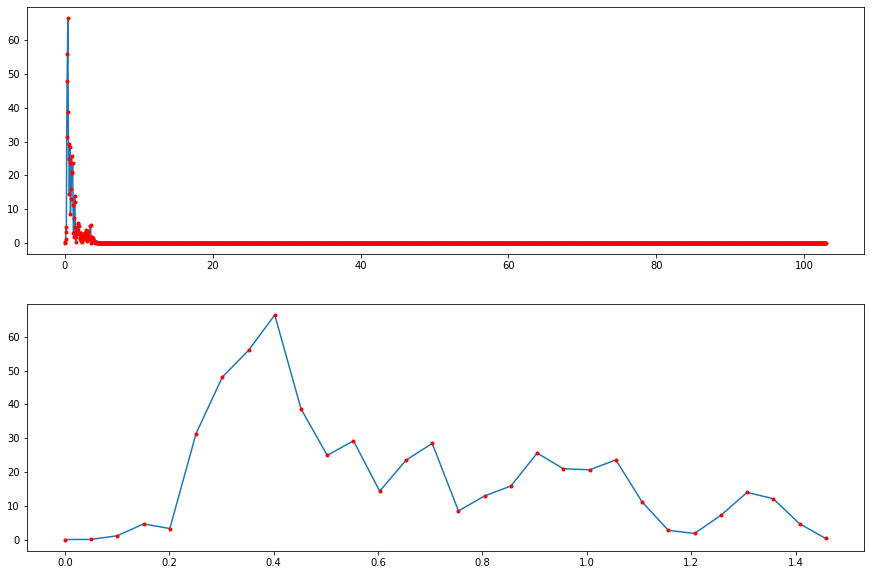

In [11]:
sig = Yf
N = len(sig)
sr = p / trng
T = 1.0 / sr

#window = signal.gaussian(len(sig), std=800)
#window = signal.blackmanharris(len(sig))
#window = signal.blackman(len(sig))
window = signal.hann(len(sig))
#window = signal.tukey(len(sig), alpha=0.8)

Xfft = np.linspace(0.0, 1.0/(2.0*T), N//2)
Yfft = fft(window * sig, p)
print(len(Xfft), len(Yfft))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = [15, 10])

ax[0].plot(Xfft, np.abs(Yfft[:N//2]))
ax[0].plot(Xfft, np.abs(Yfft[:N//2]), 'r.')

s = 0
f = 30
ax[1].plot(Xfft[s:f], np.abs(Yfft[:N//2])[s:f])
ax[1].plot(Xfft[s:f], np.abs(Yfft[:N//2])[s:f], 'r.')

#ax.plot(np.log10(Xfft[1:]), 20 * np.log10(2.0/N * np.abs(Yfft[1:N//2])))
#ax.plot(np.log10(Xfft[1:]), 20 * np.log10(2.0/N * np.abs(Yfft[1:N//2])), 'r.')

#ax.semilogy(Xfft[0:N//2], 2.0/N * np.abs(Yfft[0:N//2]))
#ax.semilogy(np.log10(Xfft[1:]), 2.0/N * np.abs(Yfft[1:N//2]))
#ax.semilogy(Xfft[1:], 2.0/N * np.abs(Yfft[1:N//2]))
#ax.semilogx(Xfft[1:], 10 * np.log10(2.0/N * np.abs(Yfft[1:N//2])), c=)

plt.show()
plt.close() # frees up memory
